# **Flooding in Italy - working code**

In [1]:
import sys; sys.path.append('/home/clair/wwa')
from wwa import *

# define smaller region for selection of data
xn = 9; xx = 14; yn = 42; yx = 46

---
## **Data pre-processing**

Datasets used:
- MSWEP: https://www.gloh2o.org/mswep/
- CHIRPS: https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p05/
- CPC: https://psl.noaa.gov/data/gridded/data.cpc.globalprecip.html
- ERA5: processed by Mariam

CPC does not capture earlier wet years, so not included in final analysis: instead, using MSWEP, ERA5 & station composite provided by Chen Lu.


### **MSWEP**



In [ ]:
# too much data to read & save in one go - save each year individually
for y in range(1979, 2021):
    
    new_fnm = "data/mswep_daily_"+"-".join([str(p) for p in [xn,xx,yn,yx]])+"_"+str(y)+".nc"
    if len(glob.glob(new_fnm)) > 0: continue

    ds = xr.open_mfdataset("/home/clair/Data/mswep_past/"+str(y)+"*.nc").sel(lon = slice(xn,xx), lat = slice(yx,yn)).rename(precipitation = "precip")
    ds.sortby(ds.lat).to_netcdf("data/mswep_daily_"+"-".join([str(p) for p in [xn,xx,yn,yx]])+"_"+str(y)+".nc")

In [2]:
for y in range(2023, 2024):
    
    new_fnm = "data/mswep_daily_"+"-".join([str(p) for p in [xn,xx,yn,yx]])+"_"+str(y)+".nc"
    if len(glob.glob(new_fnm)) > 0: continue
    
    ds = xr.open_mfdataset("/home/clair/Data/mswep_nrt/"+str(y)+"*.nc").sel(lon = slice(xn,xx), lat = slice(yx,yn)).rename(precipitation = "precip")
    ds.sortby(ds.lat).to_netcdf(new_fnm)

### **CPC**

In [12]:
cpc = xr.open_mfdataset("/home/clair/Data/cpc/precip.*.nc").sel(lon = slice(xn,xx), lat = slice(yx,yn))
cpc.sortby(cpc.lat).to_netcdf("data/cpc_daily_"+"-".join([str(p) for p in [xn,xx,yn,yx]])+".nc")

### **CHIRPS**

In [ ]:
chirps = xr.open_mfdataset("/home/clair/Data/chirps_05/*.nc").rename(latitude = "lat", longitude = "lon").sel(lon = slice(xn,xx), lat = slice(yn,yx))
chirps.sortby(chirps.lat).to_netcdf("data/chirps_daily_"+"-".join([str(p) for p in [xn,xx,yn,yx]])+".nc")

### **E-Obs**

In [3]:
eobs = xr.open_mfdataset("/home/clair/Data/e-obs_025/rr_ens_mean_0.25deg_reg_*_v26.0e.nc").rr.rename("precip", latitude = "lat", longitude = "lon").sel(lon = slice(xn,xx), lat = slice(yn,yx))
eobs.to_netcdf("data/eobs_daily_"+"-".join([str(p) for p in [xn,xx,yn,yx]])+".nc")

---
## **Local geography**
- places mentioned in trigger: Emilia-Romagna province; Bologna, Ravenna, Forli-Cesena
- Lamone river rose by over 10 metres within 24h
- also mentioned in news reports: Senio river; Ponticelli  
&nbsp;
- administrative shapefile data downloaded from http://www.diva-gis.org/gdata
- elevation data from http://research.jisao.washington.edu/data_sets/elevation/
- river & river basin shapefiles from https://www.hydrosheds.org/products/hydrobasins

In [ ]:
# load gridded elevation data
elev = xr.open_dataset("../90_data/tbase_elev-0.25deg.nc").elev.sel(lon = slice(5,20), lat = slice(35,50))

# load administrative shapefiles
sf = gpd.read_file("sf/italy-adm1").set_index("NAME_1").loc[["Emilia-Romagna", "Marche"]]

# get lat & lon of places mentioned in trigger
px = {k : get_latlon(k).values() for k in ["Bologna", "Ravenna", "Forli-Cesena", "Lamone River", "Ponticelli", "Bagnacavallo"]}

# load shapefile for river basin & clip to required extent
hb04 = gpd.read_file("sf/hybas-04").clip([xn,yn,xx,yx])

# load shapefile for rivers & clip to Emilia-Romagna region
riv = gpd.read_file("sf/hydroRIVERS/").clip(sf)

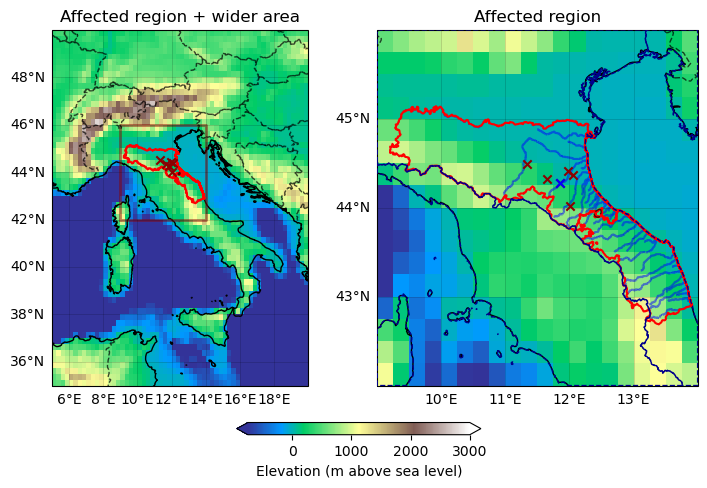

In [13]:
fig, axs = plt.subplots(ncols = 2, figsize = (9,6), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
plt.subplots_adjust(wspace = 0.05)

elev_kwargs = {"cmap" : "terrain", "vmin" : -750, "vmax" : 3000, "add_colorbar" : False}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ax = axs[0] 
cbar = elev.plot(ax = ax, **elev_kwargs)
ax.set_title("Affected region + wider area")

ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.2)

# box for smaller area
ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkred", lw = 2, alpha = 0.5)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ax = axs[1] 
elev.sel(lon = slice(xn,xx), lat = slice(yn,yx)).plot(ax = ax, **elev_kwargs)
ax.set_title("Affected region")
hb04.boundary.plot(ax = ax, color = "darkblue", lw = 1, ls = "--", zorder = 99)

ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.2, xlocs = range(xn, xx+1), ylocs = range(yn, yx+1))

riv.set_index("ORD_CLAS").loc[[1]].plot(ax = ax, color = "blue", alpha = 0.5)
[ax.scatter(*xy, marker = "x", color = "blue", zorder = 999) for k, xy in px.items() if k == "Lamone River"]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
    
    sf.boundary.plot(ax = ax, color = "red")
    [ax.scatter(*xy, marker = "x", color = "darkred", zorder = 99) for xy in px.values()]

plt.colorbar(cbar, ax = axs, location = "bottom", extend = "both", shrink = 0.35, pad = 0.08, label = "Elevation (m above sea level)")

plt.savefig("fig/physical-geography.png")

### **Shapefile**

In [41]:
# load shapefile, select region, get single largest polygon
sf = gpd.read_file("sf/italy-adm1").set_index("NAME_1").loc[["Emilia-Romagna"]].explode(index_parts = True)
sf = sf.loc[[a == sf.geometry.area.max() for a in sf.geometry.area]]
sf.to_file("sf_emilia-romagna")

/tmp/ipykernel_13523/625400598.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sf = sf.loc[[a == sf.geometry.area.max() for a in sf.geometry.area]]


---
## **Synoptic meteorology**

In [248]:
ds = xr.open_dataset("data/adaptor.mars.internal-1684761794.6905973-28942-11-44147f8c-d4f0-4626-b304-891d16305b83.nc").resample(time = "D").mean().sortby("latitude")
# slp_clim = xr.open_dataset("data/adaptor.mars.internal-1684764438.3361168-14078-4-ddc66691-f9e8-47f3-9811-be565e71e581.nc").msl.mean("time")
# slp_anom = convert_units_to(ds.msl - slp_clim, "hPa")
slp_anom = convert_units_to(ds.msl, "hPa")

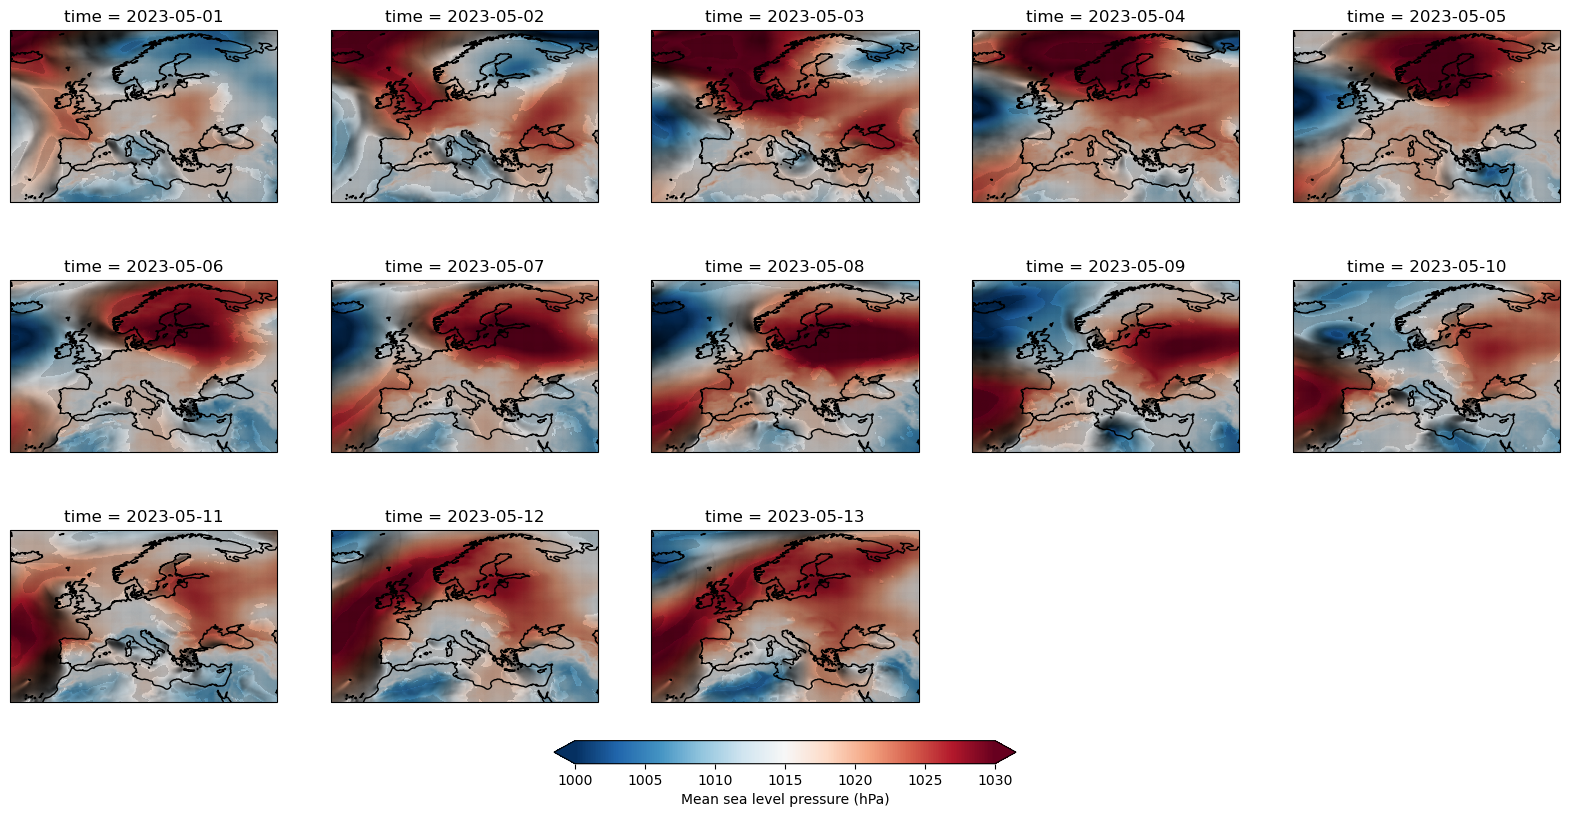

In [267]:
fig, axs = plt.subplots(ncols = 5, nrows = 3, figsize = (20,10), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

for i in range(len(ds.time)):
    ax = fig.axes[i]
    
    cbar = slp_anom.isel(time = i).plot(ax = ax, vmin = 1000, vmax = 1030, cmap = "RdBu_r", add_colorbar = False)
    ax.coastlines()
    # ax.streamplot(x = ds.longitude.values, y = ds.latitude.values, u = ds.u10.isel(time = -1).values, v = ds.v10.isel(time = -1).values, color = "k", density = .75, linewidth = 0.5)
    ax.quiver(ds.longitude, ds.latitude, ds.u10.isel(time = i), ds.v10.isel(time = i))
    
for i in range(len(ds.time), len(fig.axes)): fig.axes[i].set_axis_off()
    
plt.colorbar(cbar, ax = axs, extend = "both", label = "Mean sea level pressure (hPa)", location = "bottom", fraction = 0.03, shrink = 0.9, pad = 0.05)

---
## **Gridded datasets**

### **MSWEP**

#### **Maps of daily precip**

In [4]:
mswep_clim = xr.open_mfdataset("data/mswep_daily_9-14-42-46_19*.nc").sel(time = slice(None, "2022")).precip.groupby("time.month")[5].mean("time").load()
mswep_2023 = xr.open_mfdataset("data/mswep_daily_9-14-42-46_2023.nc").precip.groupby("time.month")[5].load()
mswep_anom = ((mswep_2023 - mswep_clim) / mswep_clim * 100)

sf = gpd.read_file("sf/italy-adm1").set_index("NAME_1").loc[["Emilia-Romagna", "Marche"]]

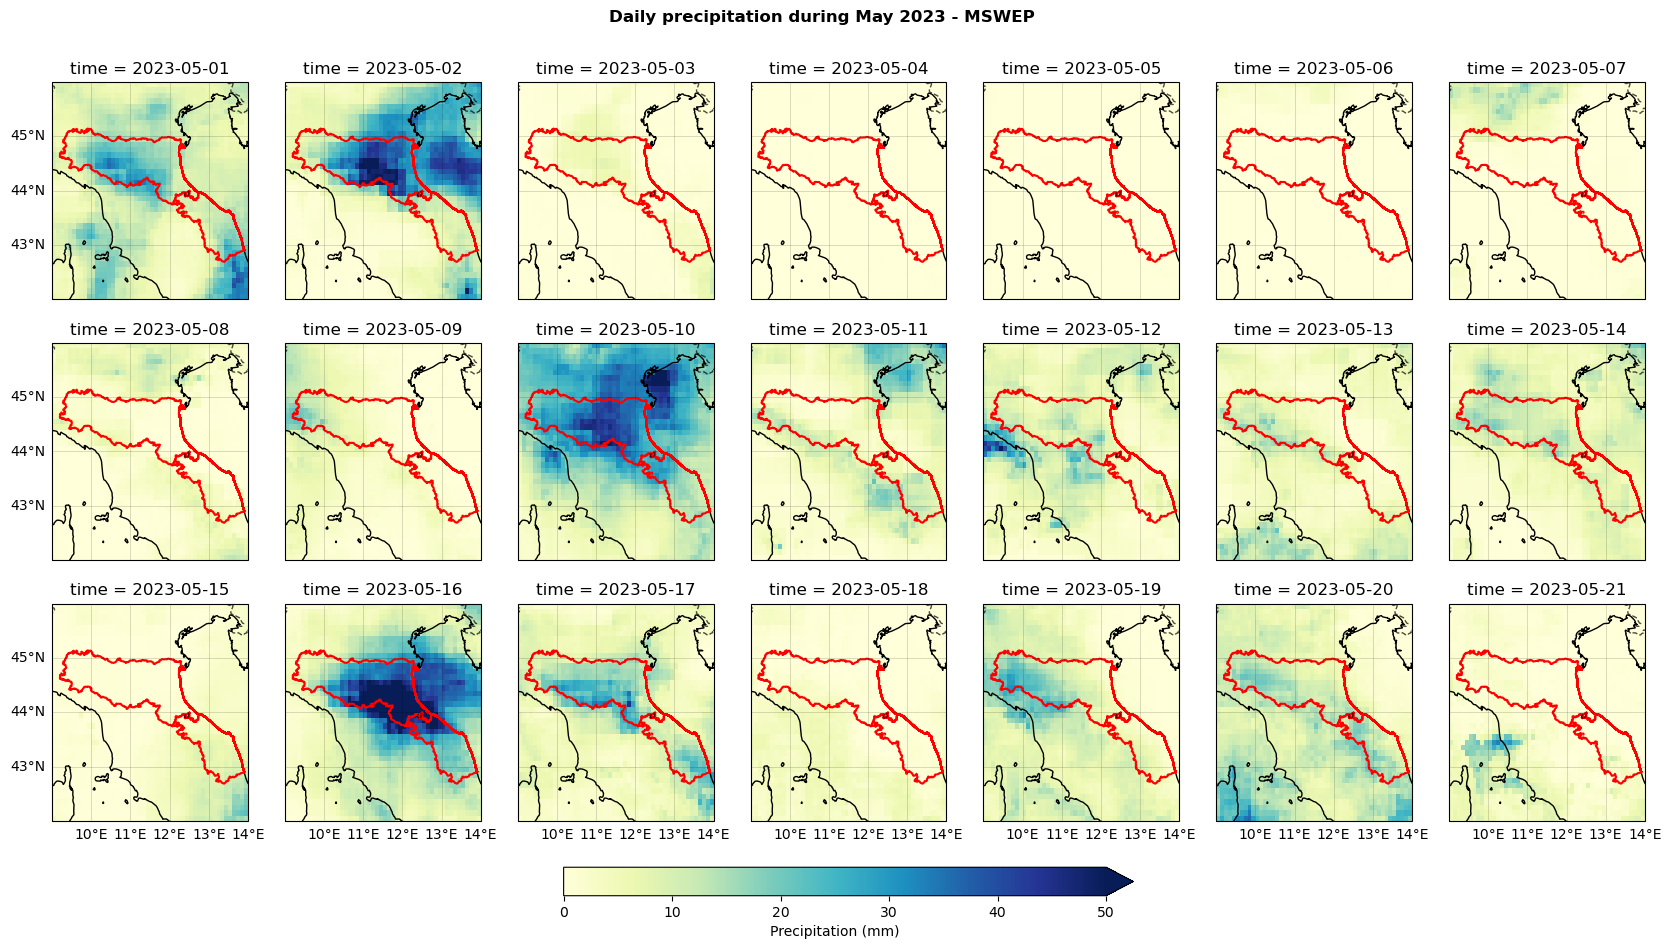

In [5]:
fig, axs = plt.subplots(ncols = 7, nrows = 3, figsize = (21,12), subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
plt.subplots_adjust(hspace = 0.2, wspace = 0.01)

for i in range(21):
    ax = fig.axes[i]
    cbar = mswep_2023.isel(time = i).plot(ax = ax, cmap = "YlGnBu", vmin = 0, vmax = 50, add_colorbar = False)
    
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
    sf.boundary.plot(ax = ax, color = "red")
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', alpha=0.2, xlocs = range(xn, xx+1), ylocs = range(yn, yx+1))
    
for ax in axs[-1,:]:
    ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels = ["bottom"], alpha=0, xlocs = range(xn+1, xx+1), ylocs = range(yn, yx+1))
for ax in axs[:,0]:
    ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels = ["left"], alpha=0, xlocs = range(xn, xx+1), ylocs = range(yn, yx+1))
    
plt.colorbar(cbar, ax = axs, location = "bottom", extend = "max", shrink = 0.35, pad = 0.05, label = "Precipitation (mm)")
plt.suptitle("Daily precipitation during May 2023 - MSWEP", fontweight = "bold", y = 0.94)

plt.savefig("fig/mswep-precip_2023-05.png")

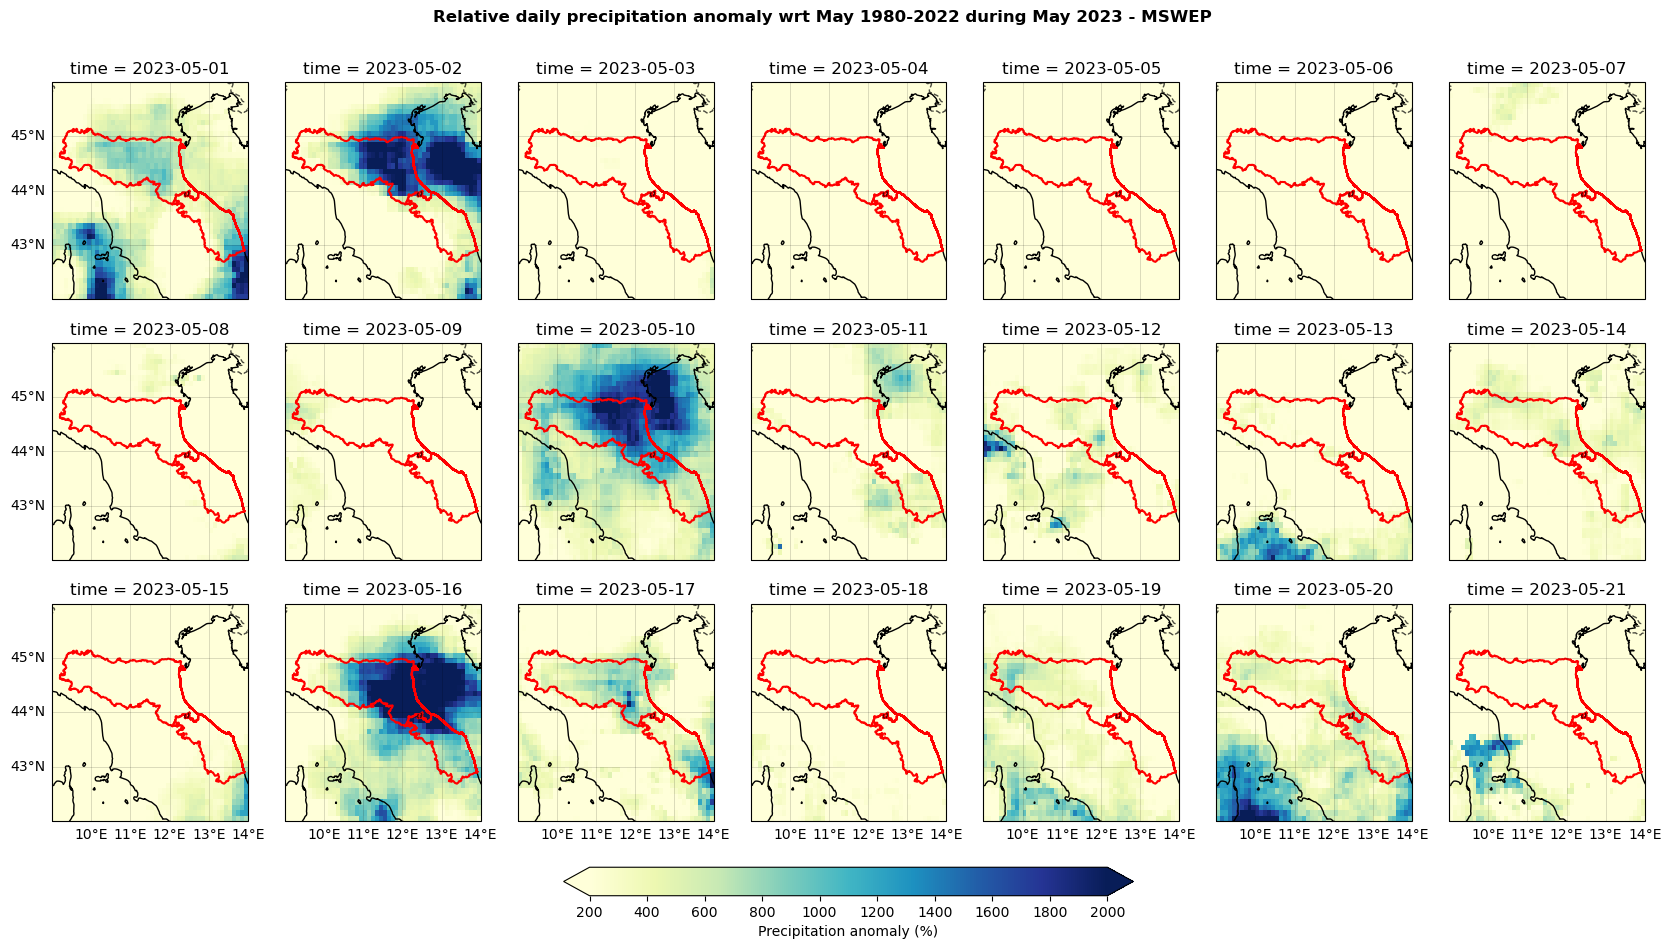

In [11]:
fig, axs = plt.subplots(ncols = 7, nrows = 3, figsize = (21,12), subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
plt.subplots_adjust(hspace = 0.2, wspace = 0.01)

for i in range(21):
    ax = fig.axes[i]
    cbar = mswep_anom.isel(time = i).plot(ax = ax, cmap = "YlGnBu", vmin = 200, vmax = 2000, add_colorbar = False)
    
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
    sf.boundary.plot(ax = ax, color = "red")
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', alpha=0.2, xlocs = range(xn, xx+1), ylocs = range(yn, yx+1))
    
for ax in axs[-1,:]:
    ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels = ["bottom"], alpha=0, xlocs = range(xn+1, xx+1), ylocs = range(yn, yx+1))
for ax in axs[:,0]:
    ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels = ["left"], alpha=0, xlocs = range(xn, xx+1), ylocs = range(yn, yx+1))
    
plt.colorbar(cbar, ax = axs, location = "bottom", extend = "both", shrink = 0.35, pad = 0.05, label = "Precipitation anomaly (%)")
plt.suptitle("Relative daily precipitation anomaly wrt May 1980-2022 during May 2023 - MSWEP", fontweight = "bold", y = 0.94)

plt.savefig("fig/mswep-precip-anompc_2023-05.png")

#### **Seasonal context**

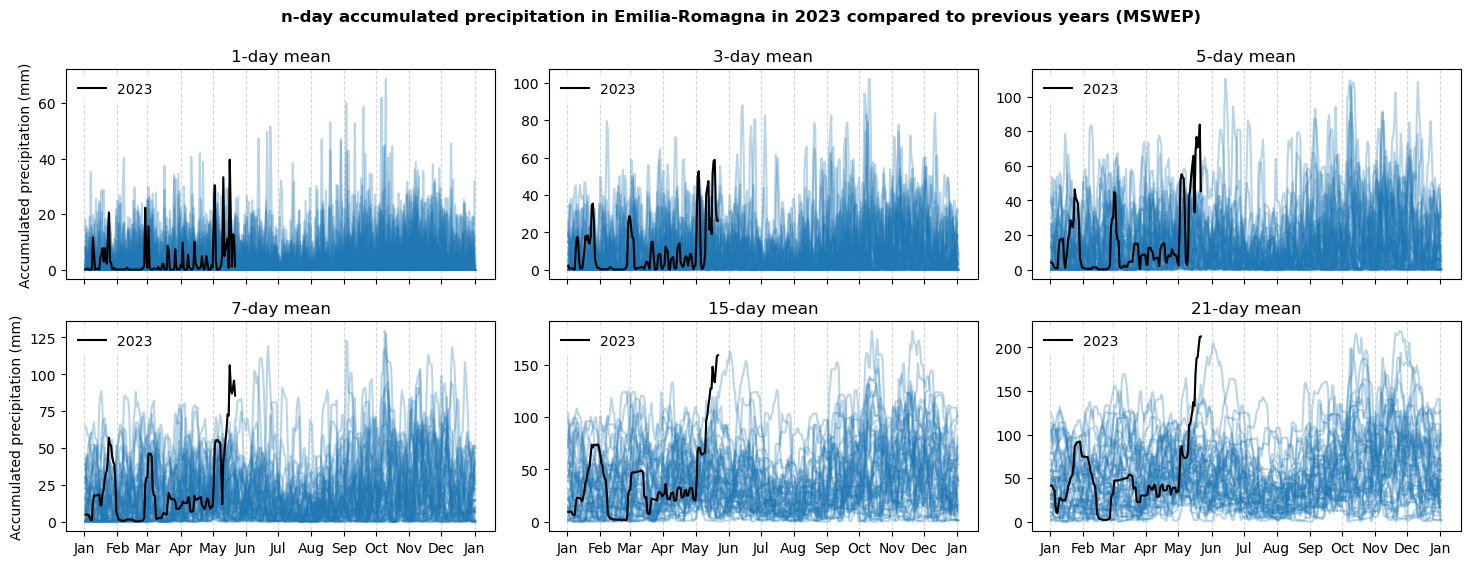

In [7]:
sf = gpd.read_file("sf/italy-adm1").set_index("NAME_1").loc[["Emilia-Romagna"]]

mswep = xr.open_mfdataset("data/mswep_daily_9-14-42-46_*.nc").precip
mswep_ts = mswep.where(regionmask.mask_3D_geopandas(sf, mswep.lon, mswep.lat, numbers = "ID_1").squeeze(drop = True) == 1).mean(["lat", "lon"]).load()

fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (18,6), sharex = True, sharey = False)
plt.subplots_adjust(hspace = 0.2, wspace = 0.125)

ndays = [1,3,5,7,15,21]

for i in range(6):
    
    ax = fig.axes[i]
    nd = ndays[i]
    ts = mswep_ts.rolling(time = nd, center = False).sum()
    
    # plot each year individually so that the overlapping transparencies interact
    for y in set(ts.time.dt.year.values): 
        ax.plot(ts.sel(time = str(y)).time.dt.dayofyear, ts.sel(time = str(y)), color = "tab:blue", alpha = 0.3)
        
    ax.plot(ts.sel(time = "2023").time.dt.dayofyear, ts.sel(time = "2023"), color = "k", label = "2023")
    ax.legend(edgecolor = "w", loc = "upper left")
    
    sc_xlabels(dates = mswep.sel(time = slice("20180101", "20190101")).time, ax = ax)
    
    ax.set_title(str(nd)+"-day mean")
    ax.grid(axis = "x", alpha = 0.5, ls = "--")
    
for ax in axs[:,0]: ax.set_ylabel("Accumulated precipitation (mm)")

fig.suptitle("n-day accumulated precipitation in Emilia-Romagna in 2023 compared to previous years (MSWEP)", fontweight = "bold")
plt.savefig("fig/mswep_n-day-precip_Emilia-Romagna.png")

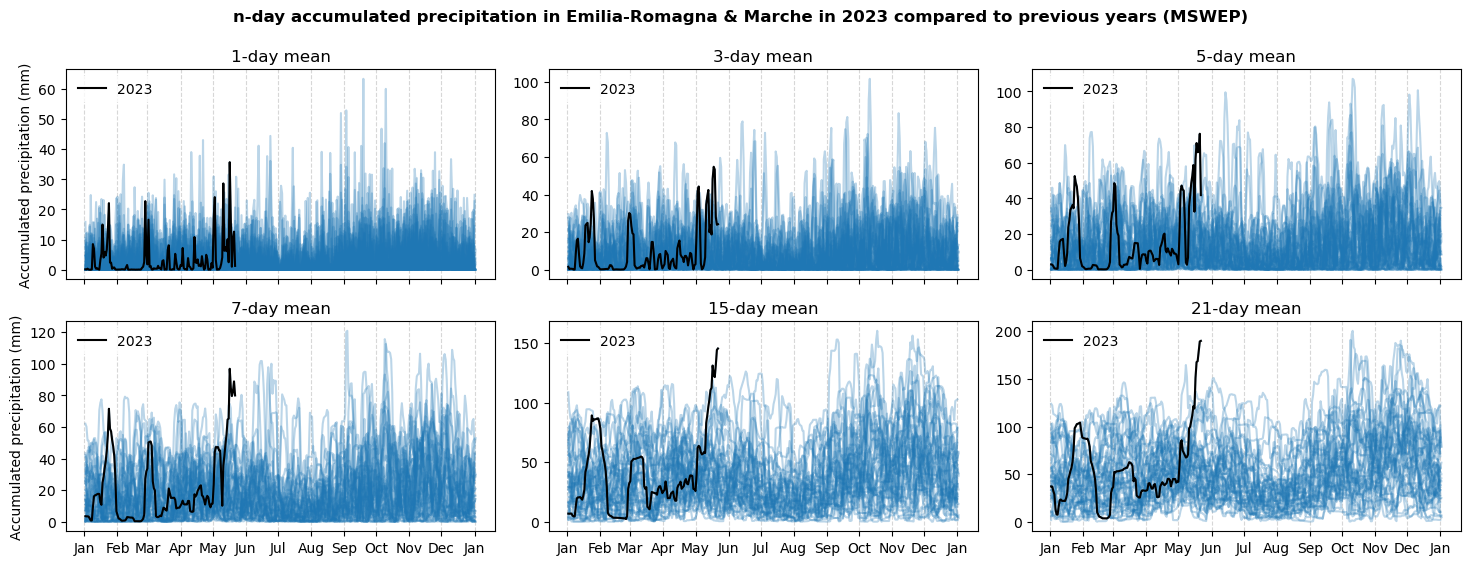

In [8]:
sf = gpd.read_file("sf/italy-adm1").set_index("NAME_1").loc[["Emilia-Romagna", "Marche"]]

mswep = xr.open_mfdataset("data/mswep_daily_9-14-42-46_*.nc").precip
mswep_ts = mswep.where(regionmask.mask_3D_geopandas(sf, mswep.lon, mswep.lat, numbers = "ID_1").sum("region") == 1).mean(["lat", "lon"]).load()

fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (18,6), sharex = True, sharey = False)
plt.subplots_adjust(hspace = 0.2, wspace = 0.125)

ndays = [1,3,5,7,15,21]

for i in range(6):
    
    ax = fig.axes[i]
    nd = ndays[i]
    ts = mswep_ts.rolling(time = nd, center = False).sum()
    
    # plot each year individually so that the overlapping transparencies interact
    for y in set(ts.time.dt.year.values): 
        ax.plot(ts.sel(time = str(y)).time.dt.dayofyear, ts.sel(time = str(y)), color = "tab:blue", alpha = 0.3)
        
    ax.plot(ts.sel(time = "2023").time.dt.dayofyear, ts.sel(time = "2023"), color = "k", label = "2023")
    ax.legend(edgecolor = "w", loc = "upper left")
    
    sc_xlabels(dates = mswep.sel(time = slice("20180101", "20190101")).time, ax = ax)
    
    ax.set_title(str(nd)+"-day mean")
    ax.grid(axis = "x", alpha = 0.5, ls = "--")
    
for ax in axs[:,0]: ax.set_ylabel("Accumulated precipitation (mm)")

fig.suptitle("n-day accumulated precipitation in Emilia-Romagna & Marche in 2023 compared to previous years (MSWEP)", fontweight = "bold")
plt.savefig("fig/mswep_n-day-precip_Emilia-Romagna-Marche.png")

### **CPC**

#### **Maps of daily precip**

In [13]:
cpc_clim = xr.open_mfdataset("data/cpc_daily_9-14-42-46.nc").sel(time = slice(None, "2022")).precip.groupby("time.month")[5].mean("time").load()

In [14]:
cpc_2023 = xr.open_mfdataset("data/cpc_daily_9-14-42-46.nc").sel(time = "2023").precip.groupby("time.month")[5].load()
cpc_anom = ((cpc_2023 - cpc_clim) / cpc_clim * 100)

sf = gpd.read_file("sf/italy-adm1").set_index("NAME_1").loc[["Emilia-Romagna", "Marche"]]

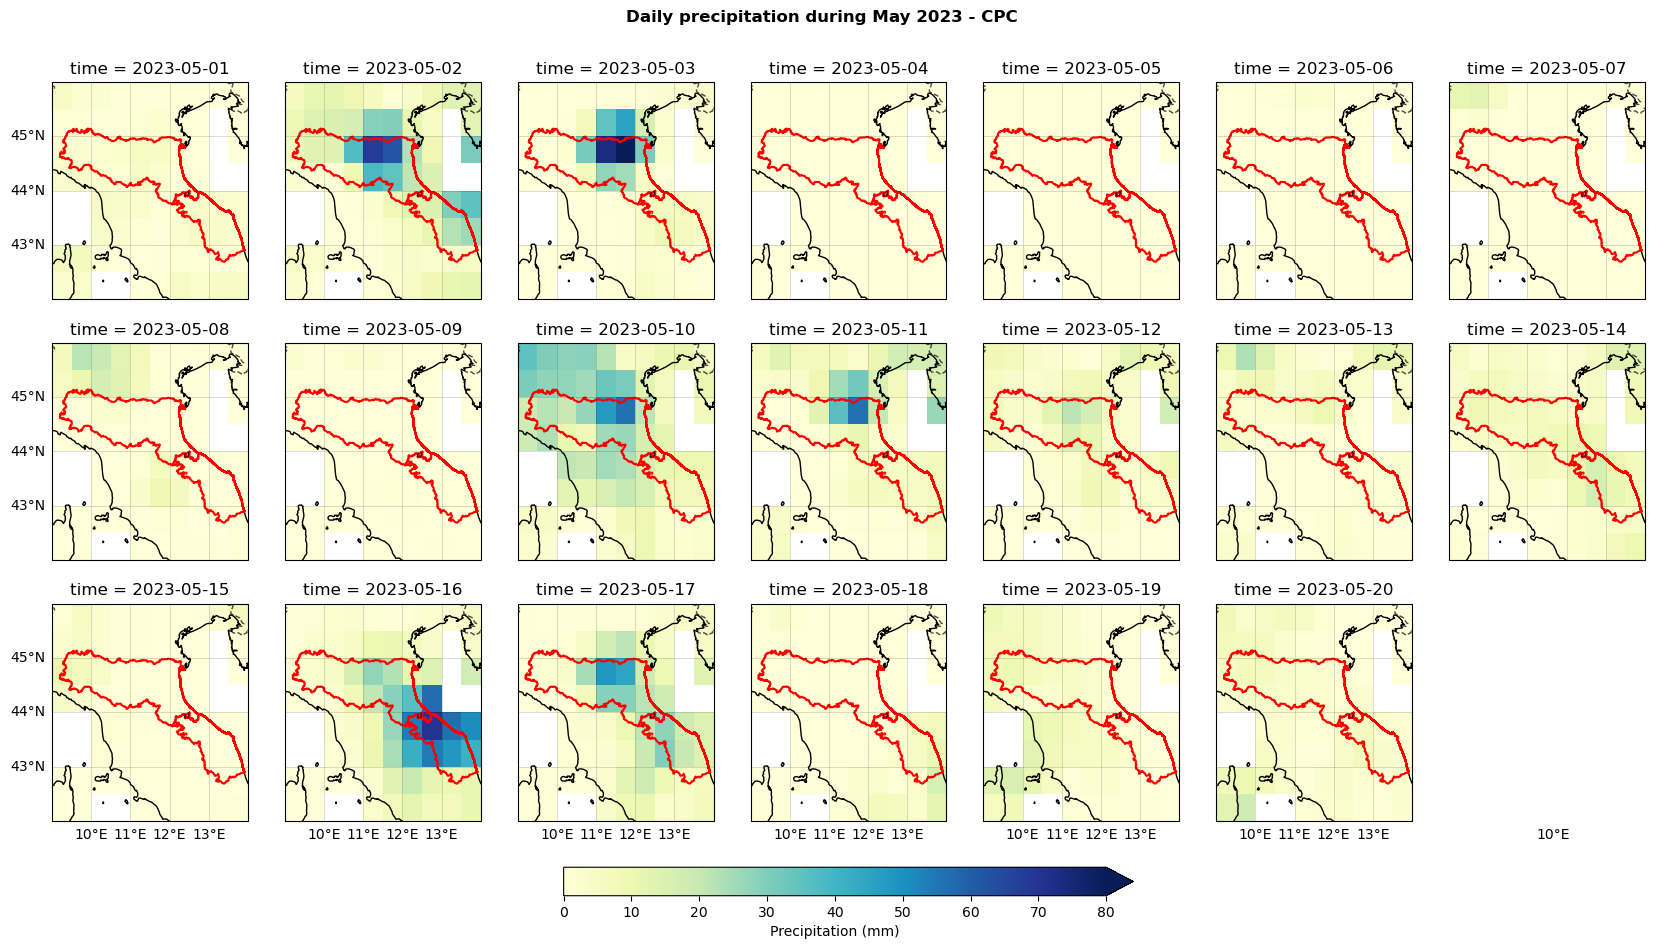

In [17]:
fig, axs = plt.subplots(ncols = 7, nrows = 3, figsize = (21,12), subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
plt.subplots_adjust(hspace = 0.2, wspace = 0.01)

for i in range(len(cpc_2023.time),21): fig.axes[i].set_axis_off()
for i in range(len(cpc_2023.time)):
    ax = fig.axes[i]
    cbar = cpc_2023.isel(time = i).plot(ax = ax, cmap = "YlGnBu", vmin = 0, vmax = 80, add_colorbar = False)
    
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
    sf.boundary.plot(ax = ax, color = "red")
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', alpha=0.2, xlocs = range(xn, xx+1), ylocs = range(yn, yx+1))
    
for ax in axs[-1,:]:
    ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels = ["bottom"], alpha=0, xlocs = range(xn+1, xx+1), ylocs = range(yn, yx+1))
for ax in axs[:,0]:
    ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels = ["left"], alpha=0, xlocs = range(xn, xx+1), ylocs = range(yn, yx+1))
    
plt.colorbar(cbar, ax = axs, location = "bottom", extend = "max", shrink = 0.35, pad = 0.05, label = "Precipitation (mm)")
plt.suptitle("Daily precipitation during May 2023 - CPC", fontweight = "bold", y = 0.94)

plt.savefig("fig/cpc-precip_2023-05.png")

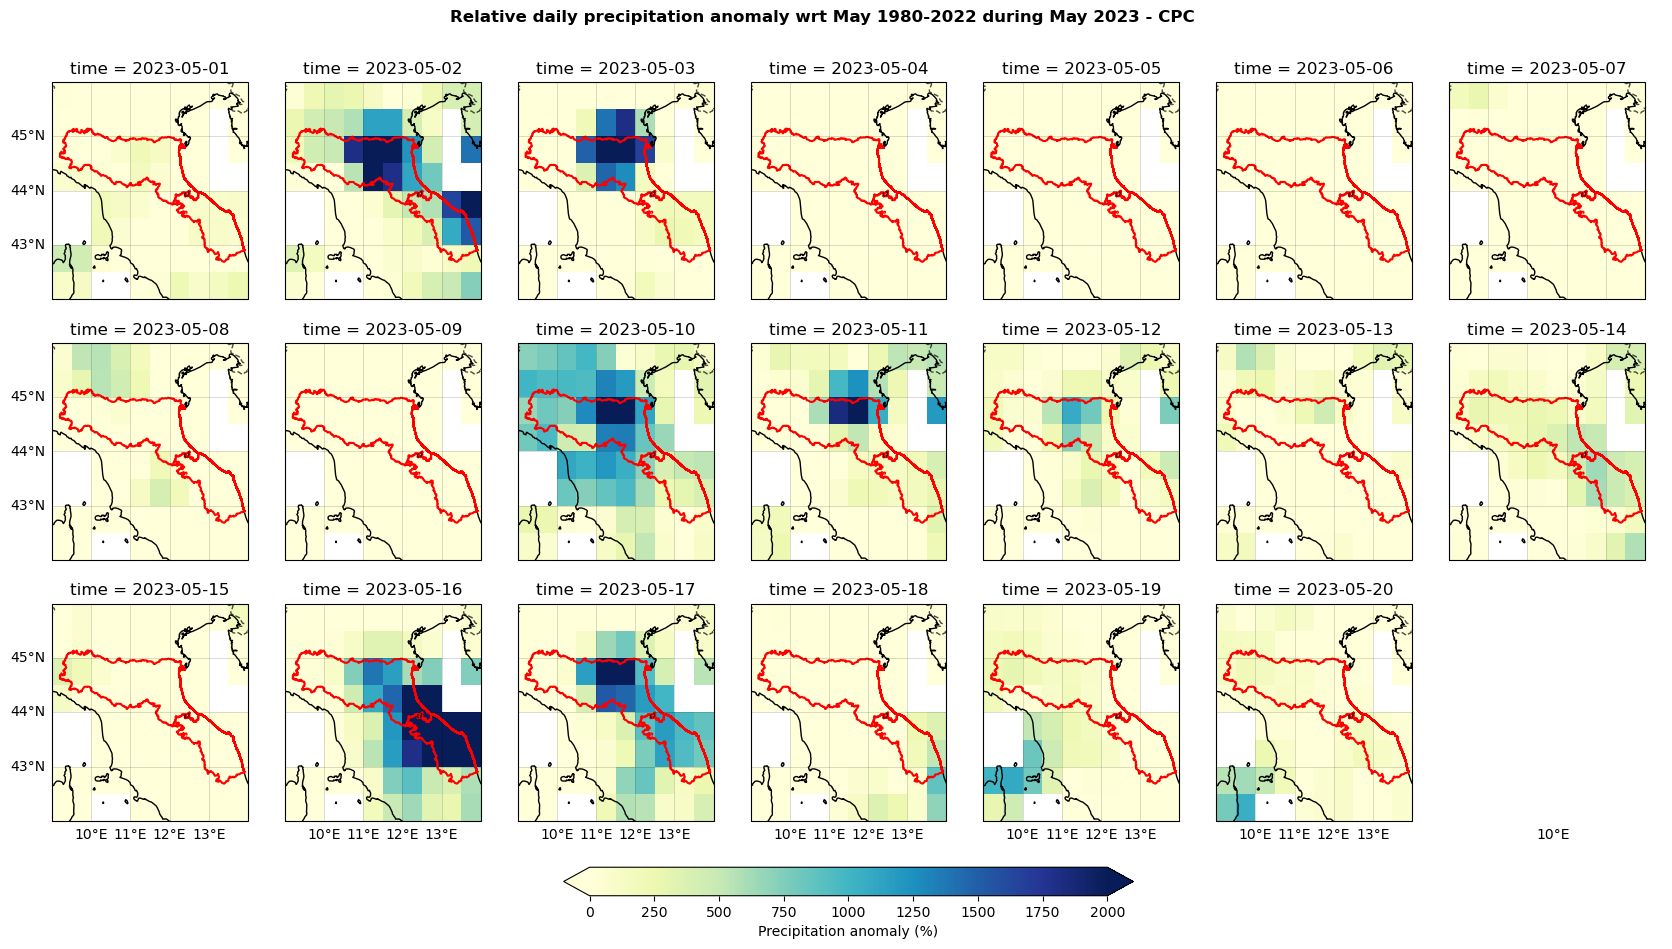

In [18]:
fig, axs = plt.subplots(ncols = 7, nrows = 3, figsize = (21,12), subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
plt.subplots_adjust(hspace = 0.2, wspace = 0.01)

for i in range(len(cpc_anom.time),21): fig.axes[i].set_axis_off()
for i in range(len(cpc_anom.time)):
    ax = fig.axes[i]
    cbar = cpc_anom.isel(time = i).plot(ax = ax, cmap = "YlGnBu", vmin = 0, vmax = 2000, add_colorbar = False)
    
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
    sf.boundary.plot(ax = ax, color = "red")
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', alpha=0.2, xlocs = range(xn, xx+1), ylocs = range(yn, yx+1))
    
for ax in axs[-1,:]:
    ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels = ["bottom"], alpha=0, xlocs = range(xn+1, xx+1), ylocs = range(yn, yx+1))
for ax in axs[:,0]:
    ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels = ["left"], alpha=0, xlocs = range(xn, xx+1), ylocs = range(yn, yx+1))
    
plt.colorbar(cbar, ax = axs, location = "bottom", extend = "both", shrink = 0.35, pad = 0.05, label = "Precipitation anomaly (%)")
plt.suptitle("Relative daily precipitation anomaly wrt May 1980-2022 during May 2023 - CPC", fontweight = "bold", y = 0.94)

plt.savefig("fig/cpc-precip-anompc_2023-05.png")

#### **Seasonal context**

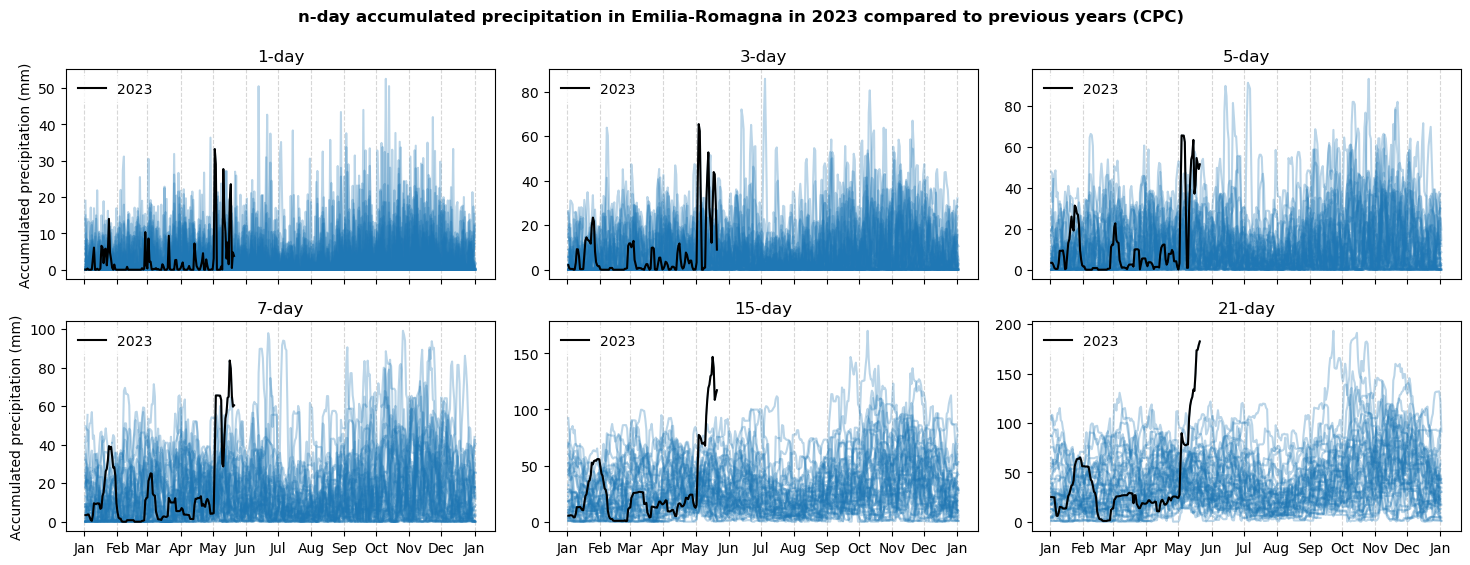

In [19]:
sf = gpd.read_file("sf/italy-adm1").set_index("NAME_1").loc[["Emilia-Romagna"]]

cpc = xr.open_dataset("data/cpc_daily_9-14-42-46.nc").precip
cpc_ts = cpc.where(regionmask.mask_3D_geopandas(sf, cpc.lon, cpc.lat, numbers = "ID_1").squeeze(drop = True) == 1).mean(["lat", "lon"]).load()

fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (18,6), sharex = True, sharey = False)
plt.subplots_adjust(hspace = 0.2, wspace = 0.125)

ndays = [1,3,5,7,15,21]

for i in range(6):
    
    ax = fig.axes[i]
    nd = ndays[i]
    ts = cpc_ts.rolling(time = nd, center = False).sum()
    
    # plot each year individually so that the overlapping transparencies interact
    for y in set(ts.time.dt.year.values): 
        ax.plot(ts.sel(time = str(y)).time.dt.dayofyear, ts.sel(time = str(y)), color = "tab:blue", alpha = 0.3)
        
    ax.plot(ts.sel(time = "2023").time.dt.dayofyear, ts.sel(time = "2023"), color = "k", label = "2023")
    ax.legend(edgecolor = "w", loc = "upper left")
    
    sc_xlabels(dates = cpc.sel(time = slice("20180101", "20190101")).time, ax = ax)
    
    ax.set_title(str(nd)+"-day")
    ax.grid(axis = "x", alpha = 0.5, ls = "--")
    
for ax in axs[:,0]: ax.set_ylabel("Accumulated precipitation (mm)")

fig.suptitle("n-day accumulated precipitation in Emilia-Romagna in 2023 compared to previous years (CPC)", fontweight = "bold")
plt.savefig("fig/cpc_n-day-precip_Emilia-Romagna.png")

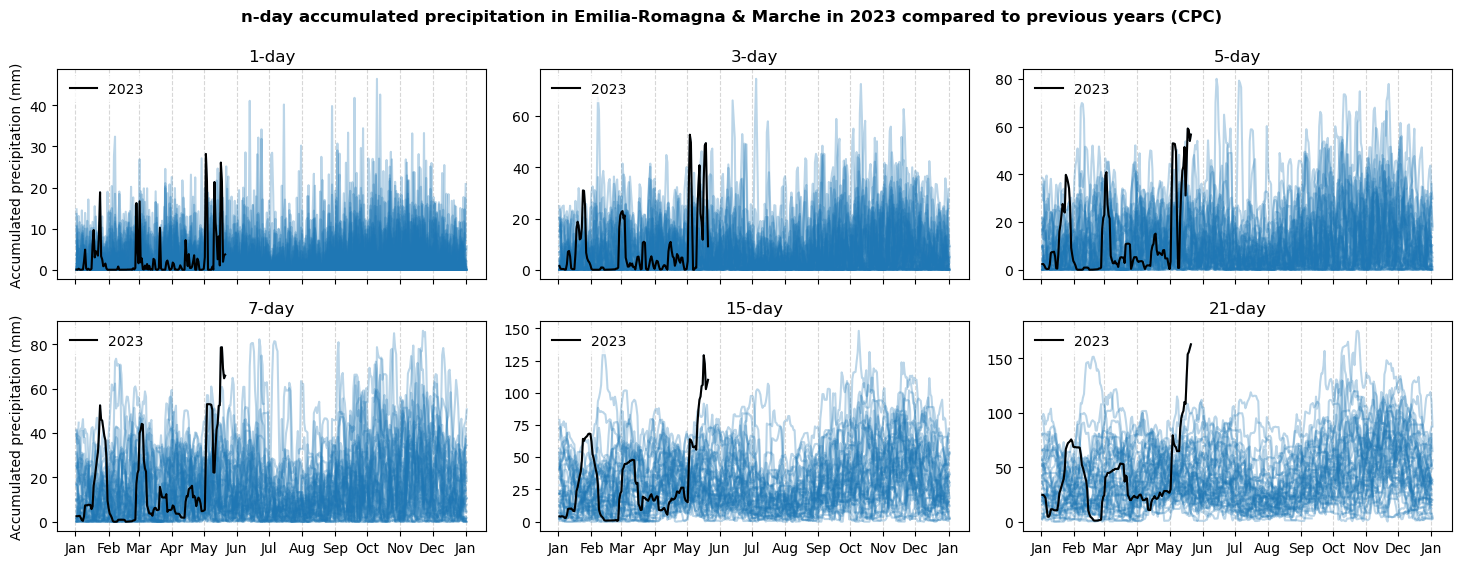

In [20]:
sf = gpd.read_file("sf/italy-adm1").set_index("NAME_1").loc[["Emilia-Romagna", "Marche"]]

cpc = xr.open_dataset("data/cpc_daily_9-14-42-46.nc").precip
cpc_ts = cpc.where(regionmask.mask_3D_geopandas(sf, cpc.lon, cpc.lat, numbers = "ID_1").sum("region") == 1).mean(["lat", "lon"]).load()

fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (18,6), sharex = True, sharey = False)
plt.subplots_adjust(hspace = 0.2, wspace = 0.125)

ndays = [1,3,5,7,15,21]

for i in range(6):
    
    ax = fig.axes[i]
    nd = ndays[i]
    ts = cpc_ts.rolling(time = nd, center = False).sum()
    
    # plot each year individually so that the overlapping transparencies interact
    for y in set(ts.time.dt.year.values): 
        ax.plot(ts.sel(time = str(y)).time.dt.dayofyear, ts.sel(time = str(y)), color = "tab:blue", alpha = 0.3, label = "_not 2023")
        
    ax.plot(ts.sel(time = "2023").time.dt.dayofyear, ts.sel(time = "2023"), color = "k", label = "2023")
    ax.legend(edgecolor = "w", loc = "upper left")
    
    sc_xlabels(dates = cpc.sel(time = slice("20180101", "20190101")).time, ax = ax)
    
    ax.set_title(str(nd)+"-day")
    ax.grid(axis = "x", alpha = 0.5, ls = "--")
    
for ax in axs[:,0]: ax.set_ylabel("Accumulated precipitation (mm)")

fig.suptitle("n-day accumulated precipitation in Emilia-Romagna & Marche in 2023 compared to previous years (CPC)", fontweight = "bold")
plt.savefig("fig/cpc_n-day-precip_Emilia-Romagna-Marche.png")

### **Validation of gridded data**

In [2]:
cpc, chirps = [xr.open_dataset("data/"+ds+"_daily_9-13-43-46.nc").precip for ds in ["cpc", "chirps"]]
eobs = xr.open_dataset("data/rr_0.25deg_reg_v25.0ee_9-13E_43-46N.nc").rr
mswep = xr.open_mfdataset("data/mswep_daily_9-13-43-46_*.nc").precip.load()

fl = sorted(glob.glob("data/pgdcngts*.nc")) + sorted(glob.glob("data/peca*.nc")) 

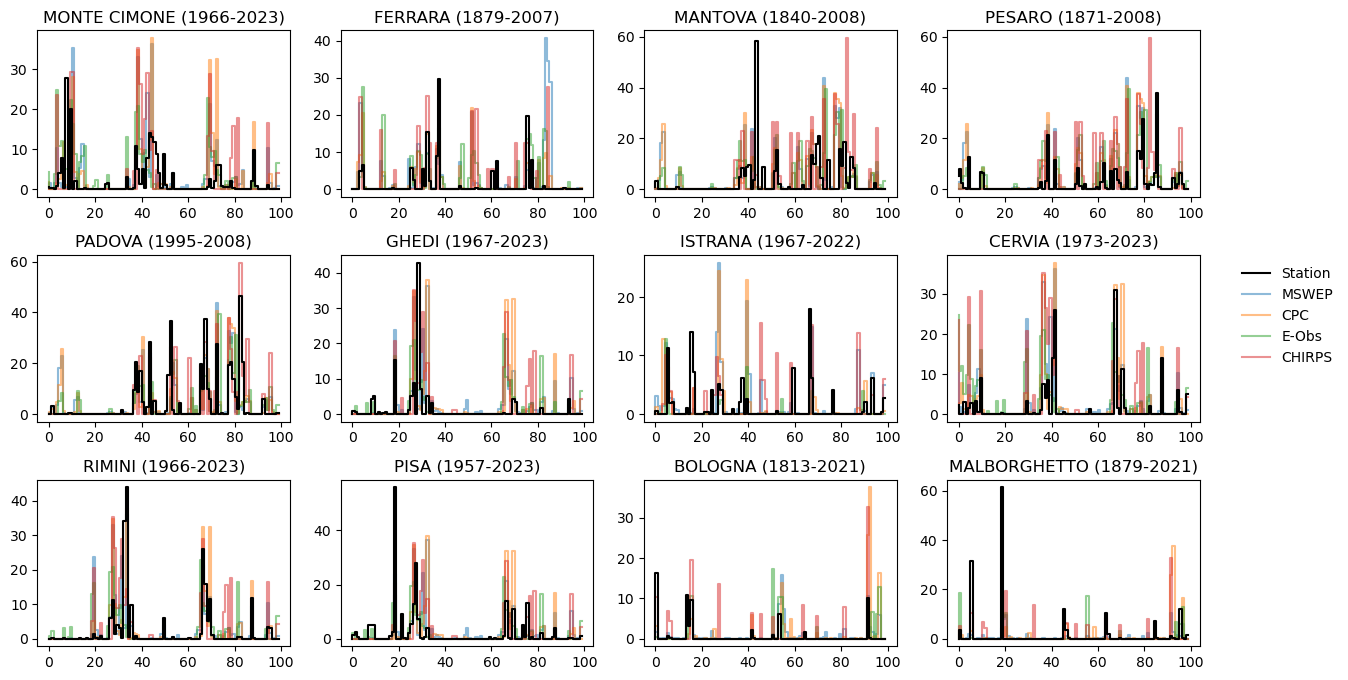

In [14]:
# in the absence of anything more sensible, look at the last 100 observations
fig, axs = plt.subplots(ncols = 4, nrows = 3, figsize = (15,8), dpi = 100)
plt.subplots_adjust(hspace = 0.35)

for i in range(len(fl)):
    
    fnm = fl[i]
    ax = fig.axes[i]
    
    da = xr.open_dataset(fnm).dropna("time", "any")
    
    lat = float(da.latitude.strip().split(" ")[0])
    lon = float(da.longitude.strip().split(" ")[0])
    stn = da.description + " ("+"-".join([str(d) for d in da.isel(time = [0,-1]).time.dt.year.values])+")"
    
    mswep_px = nearest_px(lon, lat, mswep, xcoord = "lat", ycoord = "lon")
    cpc_px = nearest_px(lon, lat, cpc, xcoord = "lat", ycoord = "lon")
    eobs_px = nearest_px(lon, lat, eobs, xcoord = "lat", ycoord = "lon")
    chirps_px = nearest_px(lon, lat, chirps, xcoord = "lat", ycoord = "lon")
    
    if "peca" in fnm:
        da = da.rr
    else:
        da = da.PRCP
    zz = xr.concat([da, mswep_px, cpc_px, eobs_px, chirps_px], "new").dropna("time", "any")
    
    ax.plot(zz.isel(new = 0, time = slice(-100,None)), color = "k", label = "Station", drawstyle = "steps", zorder = 99)
    ax.plot(zz.isel(new = 1, time = slice(-100,None)), label = "MSWEP", drawstyle = "steps", alpha = 0.5)
    ax.plot(zz.isel(new = 2, time = slice(-100,None)), label = "CPC", drawstyle = "steps", alpha = 0.5)
    ax.plot(zz.isel(new = 3, time = slice(-100,None)), label = "E-Obs", drawstyle = "steps", alpha = 0.5)
    ax.plot(zz.isel(new = 4, time = slice(-100,None)), label = "CHIRPS", drawstyle = "steps", alpha = 0.5)
    ax.set_title(stn)
    
fig.legend(["Station", "MSWEP", "CPC", "E-Obs", "CHIRPS"], bbox_to_anchor = (0.92,0.6), loc = "upper left", edgecolor = "w")
plt.savefig("fig/station-validation.png")

### **Annual maxima of different accumulations**

In [97]:
sf = gpd.read_file("sf_emilia-romagna")

mswep = xr.open_mfdataset("data/mswep_daily_9-14-42-46_*.nc").precip
cpc = xr.open_dataset("data/cpc_daily_9-14-42-46.nc").precip
era5 = xr.open_dataset("data/era5_tp_daily_eu_extended_9-13E_43-46N.nc").tp

mswep_ts, cpc_ts, era5_ts = [da.where(regionmask.mask_3D_geopandas(sf, da.lon, da.lat, numbers = "ID_1").squeeze(drop = True) == 1).mean(["lat", "lon"]).load() for da in [mswep, cpc, era5]]

In [98]:
rxnday = {nd : [ts.rolling(time = nd, center = False).sum().sel(time = [m in [4,5,6] for m in ts.time.dt.month]).resample(time = "AS-JAN").max() for ts in [mswep_ts, cpc_ts, era5_ts]] for nd in [15,21]}

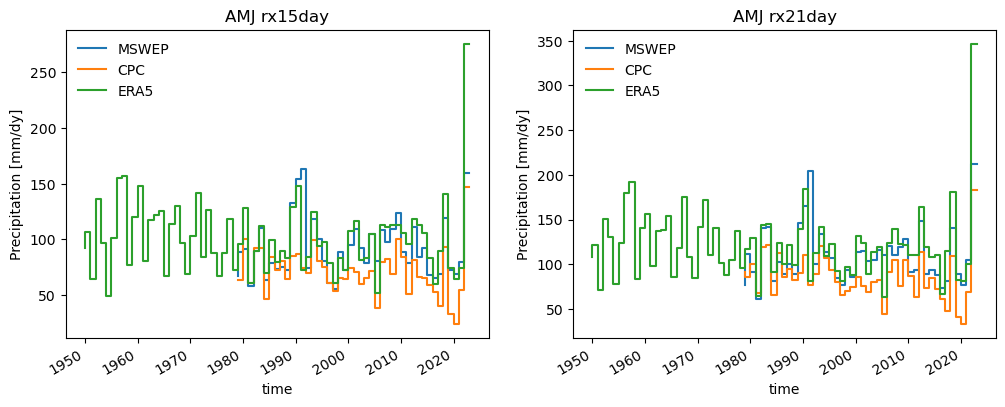

In [101]:
fig, axs = plt.subplots(ncols = len(rxnday), figsize = (6*len(rxnday),4), dpi = 100)

for i in range(len(rxnday)):
    
    ax = axs[i]
    nd = list(rxnday.keys())[i]
    
    rxnday[nd][0].plot(ax = ax, drawstyle = "steps", label = "MSWEP")
    rxnday[nd][1].plot(ax = ax, drawstyle = "steps", label = "CPC")
    rxnday[nd][2].plot(ax = ax, drawstyle = "steps", label = "ERA5")
    
    ax.set_title("AMJ rx"+str(nd)+"day")
    ax.legend(edgecolor = "w")
    
plt.savefig("fig/obs_rxnday_emilia-romagna.png")
    

---
## **Time series**

### **Gridded products**

In [36]:
## TIME SERIES FOR CLIMATE EXPLORER

mswep = xr.open_mfdataset("data/mswep_daily_9-14-42-46_*.nc").precip
era5 = xr.open_dataset("data/era5_tp_daily_eu_extended_9-13E_43-46N.nc").tp

sf = gpd.read_file("sf_emilia-romagna")
mswep_ts, era5_ts = [da.where(regionmask.mask_3D_geopandas(sf, da.lon, da.lat, numbers = "ID_1").squeeze(drop = True) == 1).mean(["lat", "lon"]).load() for da in [mswep, era5]]

for ds_nm in ["mswep", "era5"]:

    # load data, compute index
    ts = eval(ds_nm+"_ts")
    ts = ts.rolling(time = 21, center = False).sum().sel(time = [m in [4,5,6] for m in ts.time.dt.month]).resample(time = "AS-JAN").max()
    

    # fix filename
    csv_fnm = "ts/Italy-floods_rx21day-amj_"+ds_nm+".dat"
    if len(csv_fnm.split("/")[-1]) > 65: print("! Filename too long: ", csv_fnm)
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: "+ds_nm.upper()+" rx21day-AMJ - Italy floods 2023, c.barnes22@imperial.ac.uk"
    str2 = "# rx1day [mm] April/May/June maxima of 21-day accumulated precipitation over Emilia-Romagna region at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year rx21day"
    
    # make .dat file
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    ts.assign_coords(time = ts.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

In [20]:
# Smoothed GMST time series: create CSV with headers for upload to Climate Explorer

gmst = pd.read_csv("../90_data/gmst.dat", comment = "#", sep = " +", engine = "python", header = None, names = ["year","gmst"], index_col = "year")

csv_fnm = "ts/Italy-floods_gmst-smoothed.dat"
str1 = "# contact :: smoothed GMST - Italy floods 2023, c.barnes22@imperial.ac.uk"
str2 = "# gmst [decC] May 2023 snapshot of giss_al_gl_m_4yrlo from KNMI Climate Explorer at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
head = "# year gmst"

! echo "$str1 " > $csv_fnm
! echo "$str2" >> $csv_fnm
! echo "$head" >> $csv_fnm

gmst.to_csv(csv_fnm, sep = " ", mode = "a", header = False)

### **CORDEX**

In [ ]:
# quickly extract rx21day & save as txt file for easier processing in R (need to do this properly if using)
for fnm in glob.glob("cordex/*ts.nc"):
    
    ts = xr.open_dataset(fnm).pr
    ts = ts.rolling(time = 21, center = False).sum().sel(time = [m in [4,5,6] for m in ts.time.dt.month]).resample(time = "AS-JAN").max()
    
    # fix filename
    csv_fnm = "ts/Italy-floods_rx21day-amj_"+fnm.split("_")[1]+"_"+cordex_model(fnm)+".dat"
    if len(csv_fnm.split("/")[-1]) > 65: print("! Filename too long: ", csv_fnm)
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CORDEX EUR-11 "+cordex_model(fnm)+" rx21day-AMJ - Italy floods 2023, c.barnes22@imperial.ac.uk"
    str2 = "# rx1day [mm] April/May/June maxima of 21-day accumulated precipitation over Emilia-Romagna region at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year rx21day"
    
    # make .dat file
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    ts.assign_coords(time = ts.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

In [11]:
# copy required CMIP5 GMST files to study folder
for gcm in list(set(["_rcp85_".join(cordex_model(fnm).split("_")[:2]) for fnm in glob.glob("cordex/*ts.nc")])):
    
    gsat_fnm = glob.glob("../00_gsat/cmip5_smoothed-gsat*"+gcm+".dat")
    if len(gsat_fnm) == 0:
        print("No GSAT:", gcm)
        continue
        
    gsat_fnm = gsat_fnm[0]
    new_fnm = "ts/Italy-floods_"+gsat_fnm.split("/")[-1]
    if len(new_fnm.split("/")[-1]) > 65: print("Filename too long:", new_fnm)
    
    ! cp $gsat_fnm $new_fnm